In [1]:
import sys
import os

# # Simple approach: add the parent directory to Python path
# project_root = os.path.dirname(os.getcwd())
# sys.path.insert(0, project_root)
# print(f"Added {project_root} to Python path")
# print(f"Current working directory: {os.getcwd()}")

import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_filling_half_t_4_em4_rerun_mesh_60_pmap.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(1.8257612015570857e-06)

In [4]:
np.max(final_e_difference)

np.float64(9.960399394159936e-09)

### Phase Analysis

In [5]:
from functions_parameters.tools import rot_symm_m_check_d
from functions_parameters.universal_parameters import pauli_matrices

c_6 = np.array([[0,0,1],
               [1,0,0],
               [0,1,0]])
c_3 = c_6@c_6
c_2 = c_6 @ c_3

In [6]:
nematic_phase = ['R symmetric', 'C3 charge nematic', 'C2 charge nematic', 'no R']
Magnetism_phase = [' +', ' FM', ' AFM']

phase_list_final = list(i+j for i,j in product(nematic_phase, Magnetism_phase))

In [7]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)

In [8]:
threshold = 1E-6

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
gs_m = np.zeros(u_mesh.shape)
gs_n = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording = np.zeros((4))
        m_recording = np.zeros((3))
        c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
        gs_n[i,j] = c6_diff
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        # else:
        #     rs_recording[3] = 1
        gs_m[i,j] = np.max(np.abs(magnetism_arr))
        if np.max(np.abs(magnetism_arr))>threshold:
            sign = np.sign(np.sum(np.sign(magnetism_arr)))
            offsetted_magnetism_arr = magnetism_arr - sign*1e-9
            if np.min(offsetted_magnetism_arr)*sign>0:
                m_recording[1] = 1
            else:
                m_recording[2] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(rs_recording,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        # it this right???????
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'filling = 1')

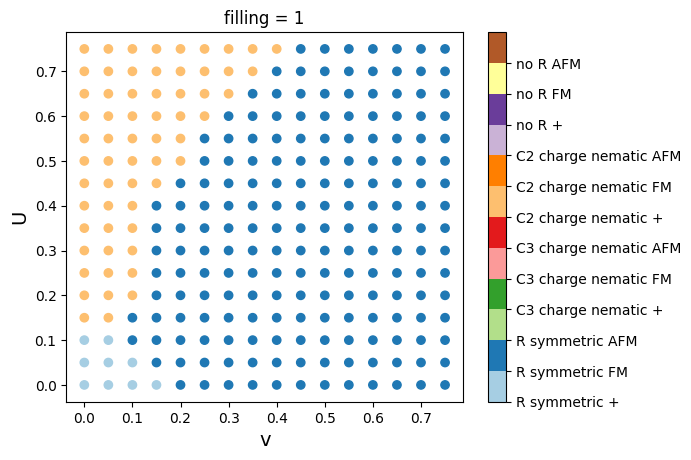

In [9]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(u_mesh, v1_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('filling = 1')

In [10]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

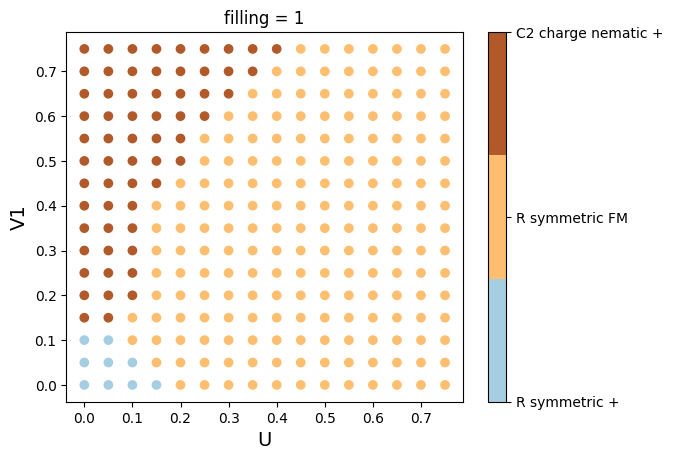

In [11]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(u_mesh, v1_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('U', size = '14')
plt.ylabel('V1', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

Text(0.5, 1.0, 'filling = 1')

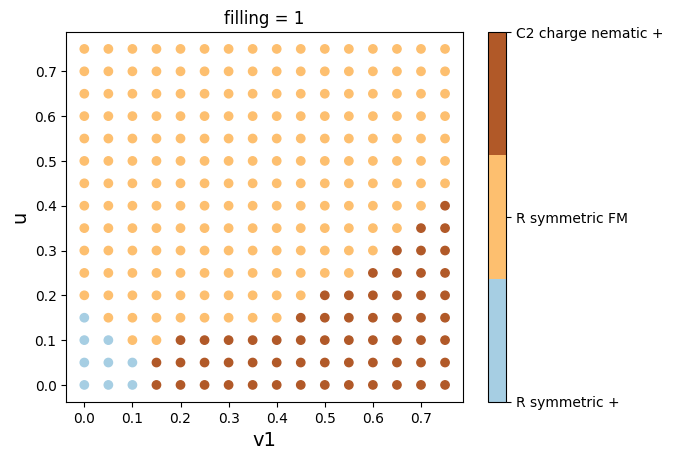

In [12]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

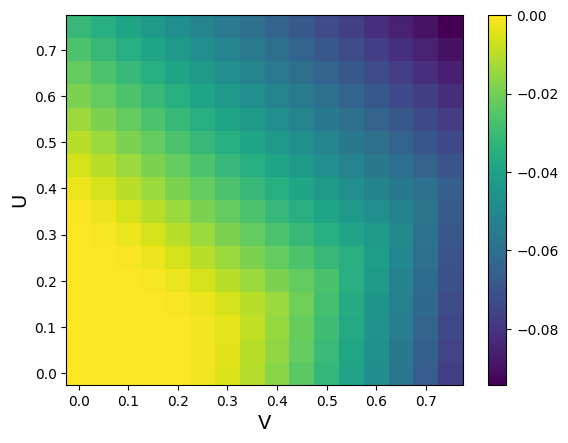

In [13]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

Text(0.5, 1.0, 'ground state c_6_diff')

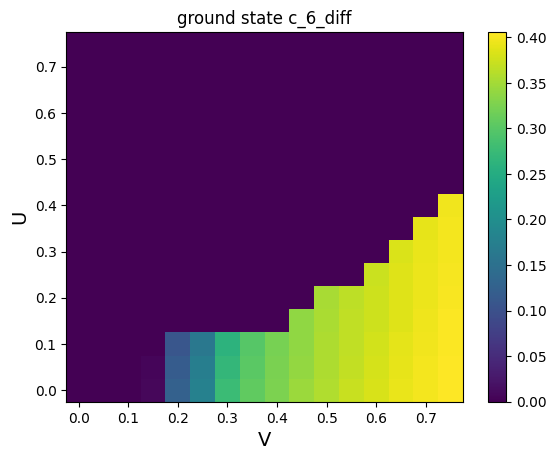

In [14]:
plt.pcolormesh(v1_mesh,u_mesh,gs_n)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state c_6_diff')

Text(0.5, 1.0, 'ground state max magnetization')

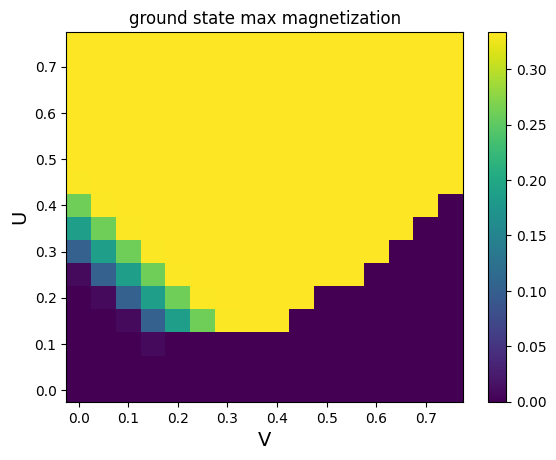

In [15]:
plt.pcolormesh(v1_mesh,u_mesh,gs_m)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state max magnetization')

In [16]:
from functions_parameters.jax_schf_helpers import *
from functions_parameters.bond_table_generator import build_buckets_per_shell

basis_frac = np.array([[1/2, 0], [1/2, 1/2], [0, 1/2]])
norb = basis_frac.shape[0]
num_k_mesh = 60
b_0 = np.linspace(-b[0] / 2, b[0] / 2, num_k_mesh, endpoint=False)
b_1 = np.linspace(-b[1] / 2, b[1] / 2, num_k_mesh, endpoint=False)
k_mesh_points = np.vstack([v1 + v2 for v1, v2 in product(b_0, b_1)])
num_k_points = k_mesh_points.shape[0]

radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

# in this case, as both TB model and interaction, we include up to NNN, the a_list and deltas are the same
# calculate the correlation matrix
temperature = 4E-4
filling = 1/2
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])

phase_pos, phase_neg = precompute_k_phase_tables(deltas, a, k_mesh_points)
Htb, e_all, v_all, v_all_dagger = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg)

nk = e_all.shape[0]
norb = e_all.shape[1]
e_fermi_iterated, ne, converged, iters = fermi_level_bisection_core(e_all, filling, temperature)
electron_count = occ(e_all, e_fermi_iterated, temperature)
# (U @ diag(electron_count) @ U_d).T
corr_k = jnp.einsum('Nni,Ni,Nim->Nmn', v_all, electron_count, v_all_dagger)
# count the spin degeneracy
gs_e = jnp.einsum('Nji, Nji->', Htb, corr_k)/nk*2

# then obtain the mean field decomposition and corresponding 
bond_ref = bond_orders_from_phases(a_lists, corr_k, phase_neg)
bond_ref = np.stack((bond_ref, bond_ref), axis=1)

bond_difference = final_bond[:,:,0] - bond_ref[np.newaxis,np.newaxis,:]

In [17]:
bond_difference.shape

(16, 16, 9, 2, 2, 3, 3)

In [18]:
bond_difference_ij = np.sqrt(np.sum(np.abs(bond_difference), axis=(2,3,4,5,6)))

Text(0.5, 1.0, 'ground state max magnetization')

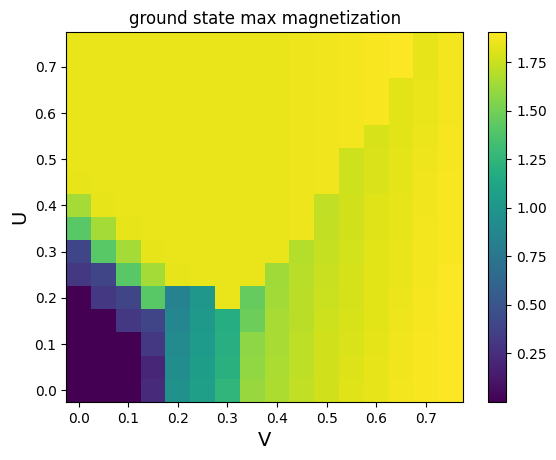

In [19]:
plt.pcolormesh(v1_mesh,u_mesh,bond_difference_ij)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state max magnetization')

## Select states for next run

In [20]:
selected_indexes = [(4,-1,0), (5,-5,0), (-5,-3,0), (-5,-2,0), (0,-1,0), (-2,-3,0), (-1,0,0), (-1,-6,0)]

In [21]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
degenerate_state_diagram = -np.ones((len(states_index[0]),)*3)
for index in states_index:
    i = index[0]
    j = index[1]
    k = index[2]
    d_o = sorted_density[i,j,k]
    rs_recording = np.zeros((4))
    m_recording = np.zeros((3))
    c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
    if c6_diff<threshold:
        rs_recording[0] = 1
    elif c6_diff>threshold and c3_diff<threshold:
        rs_recording[1] = 1
    elif c2_diff<threshold and c6_diff>threshold:
        rs_recording[2] = 1
    else:
        rs_recording[3] = 1
    if np.max(np.abs(magnetism_arr))>threshold:
        sign = np.sign(np.sum(np.sign(magnetism_arr)))
        offsetted_magnetism_arr = magnetism_arr - sign*1e-9
        if np.min(offsetted_magnetism_arr)*sign>0:
            m_recording[1] = 1
        else:
            m_recording[2] = 1
    else:
        m_recording[0] = 1
    phase_arr = np.kron(rs_recording,m_recording)
    phase = np.where(phase_arr>0.5)[0][0]
    if phase != phase_diagram_based_on_d[i,j]:
        degenerate_state_diagram[i,j,k]=phase


In [22]:
degenerate_index = np.where(degenerate_state_diagram>0)

In [23]:
phase_list_final[np.int32(degenerate_state_diagram[6,7,8])]

'no R AFM'

In [24]:
selected_indexes.append(degenerate_index)

In [25]:
selected_indexes.append((4,-1,0))

In [26]:
selected_d = np.zeros((len(selected_indexes),2,norb), dtype=np.complex128)
selected_bond = np.zeros((len(selected_indexes),)+sorted_bond[0,0,0].shape, dtype=np.complex128)
count = 0
for index in selected_indexes:
    i = index[0]
    j = index[1]
    k = index[2]
    selected_d[count] = sorted_density[i,j,k]
    selected_bond[count] = sorted_bond[i,j,k]
    count += 1

In [27]:
selected_d.shape

(10, 2, 3)

In [28]:
import os

In [29]:
np.savez_compressed("filling_1_rerun_basis_v1_V2.npz",
    d = selected_d,
    bond = selected_bond,
)

In [30]:
selected_d[8]

array([[0.11213101+8.19965210e-26j, 0.13938761+1.37041546e-19j,
        0.24848137+1.88621263e-20j],
       [0.11213101+8.19965210e-26j, 0.13938761+1.37041546e-19j,
        0.24848137+1.88621263e-20j]])

In [31]:
len(states_index[0])

263

In [32]:
sorted_density[-6,-1,0]

array([[3.33333346e-01+4.82718605e-20j, 3.33333328e-01-8.95277717e-20j,
        3.33333325e-01+9.82808813e-21j],
       [8.75651076e-27-5.07780425e-50j, 8.75651076e-27+2.51036148e-45j,
        8.75651076e-27+6.96794574e-46j]])

In [33]:
sorted_density[-6,-1,0,0] - sorted_density[-6,-1,0,1]

array([0.33333335+4.82718605e-20j, 0.33333333-8.95277717e-20j,
       0.33333333+9.82808813e-21j])

In [34]:
sorted_ground_state_e[5,5]

array([-0.01013201, -0.01013201, -0.01013201, -0.01013201, -0.01013201,
       -0.01013201, -0.01013201, -0.00089384, -0.00089384, -0.00089384])

In [35]:
sorted_ground_state_e[4,5]

array([-0.00596388, -0.00596387, -0.00596387, -0.00107279, -0.00107279,
       -0.00107279, -0.00107279, -0.00107279, -0.00106918, -0.00106918])

In [36]:
sorted_density[4,5,0]

array([[0.33265768-3.52194496e-24j, 0.33265768-6.55939313e-20j,
        0.33265768+1.02336905e-20j],
       [0.00067565-3.11929158e-33j, 0.00067565+9.26930316e-22j,
        0.00067565-8.08605002e-22j]])

In [37]:
sorted_density[4,5,6]

array([[0.14654891+3.51152505e-26j, 0.22216538-1.28842477e-19j,
        0.14654891-1.27881249e-20j],
       [0.1375217 +1.36904701e-26j, 0.20969341-7.14577918e-21j,
        0.1375217 -6.54101551e-20j]])

In [38]:
sorted_ground_state_e_index[4,5]

array([6, 7, 8, 1, 0, 9, 3, 2, 5, 4])

In [39]:
final_bond[4,5,2]

array([[[[[-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [ 0.        -0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j]],

         [[-0.        +0.00000000e+00j,  0.11512903-2.58244301e-17j,
            0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
            0.        -0.00000000e+00j],
          [ 0.        -0.00000000e+00j,  0.08274723-2.52514848e-17j,
            0.        +0.00000000e+00j]]],


        [[[ 0.        -0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j],
          [-0.        +0.00000000e+00j,  0.        -0.00000000e+00j,
           -0.        +0.00000000e+00j],
          [ 0.        -0.00000000e+00j,  0.        +0.00000000e+00j,
            0.        +0.00000000e+00j]],

  

In [40]:
la.norm(np.abs(final_bond[4,5,4] - final_bond[4,5,2])) 

np.float64(0.31071631178154574)

In [41]:
sorted_density[6,5,0]

array([[3.33333280e-01-5.95803618e-24j, 3.33333277e-01+1.82442213e-19j,
        3.33333442e-01-7.88862140e-20j],
       [8.75651076e-27-9.89350759e-51j, 8.75651076e-27-1.96401765e-45j,
        8.75651076e-27+3.79644170e-45j]])

In [42]:
sorted_ground_state_e[-2,-1]

array([-0.0901301 , -0.09013009, -0.08929536, -0.05827108, -0.05827108,
       -0.05827108, -0.05827108, -0.05827108, -0.05827108, -0.05827108])

In [43]:
sorted_density[-2,-1,0]

array([[3.33333346e-01-2.55942037e-20j, 3.33333328e-01-2.61022970e-20j,
        3.33333325e-01-1.65492652e-19j],
       [8.75651076e-27-1.12891090e-48j, 8.75651076e-27-9.59623036e-45j,
        8.75651076e-27+4.04157948e-47j]])

In [44]:
sorted_density[-2,-1,6]

array([[0.23174494-7.39961572e-26j, 0.03651025+1.40464574e-20j,
        0.23174481-4.71823288e-20j],
       [0.23174494-7.39961572e-26j, 0.03651025+1.40464574e-20j,
        0.23174481-4.71823288e-20j]])

In [45]:
np.mean(final_iteration)

np.float64(53.526953125)

In [46]:
np.max(final_iteration)

np.int32(500)

In [47]:
np.min(final_iteration)

np.int32(2)

### Test the degeneracy of energy